# Learning from images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/deeplearning_with_pytorch")

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)

In [ ]:
# use cifar10 data to train the network 
from torchvision import datasets
data_path = './data-unversioned'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


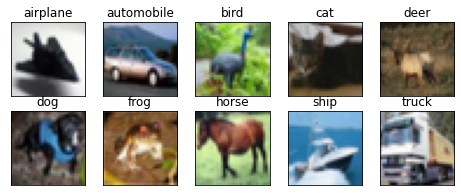

In [ ]:
class_names = ['airplane', 'automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

In [ ]:
type(cifar10).__mro__ # possible methods

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [ ]:
len(cifar10)

50000

In [ ]:
# sample image
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F206187F3D0>,
 1,
 'automobile')

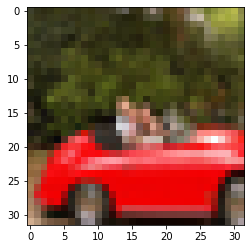

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
# use transforms to transform the image
from torchvision import transforms
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'Enum',
 'F',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'List',
 'Normalize',
 'Optional',
 'PILToTensor',
 'Pad',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'Tensor',
 'ToPILImage',
 'ToTensor',
 'Tuple',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'math',
 'torch',
 'transforms']

In [ ]:
# convert to tensor
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [ ]:
# transforming the whole dataset
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                  transform=transforms.ToTensor())

In [ ]:
# changed to tensor
img_t, _ = tensor_cifar10[42]
type(img_t)

torch.Tensor

In [ ]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [ ]:
img_t.min(), img_t.max()

(tensor(0.1098), tensor(0.7529))

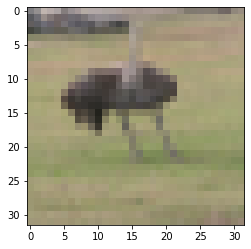

In [ ]:
plt.imshow(img_t.permute(1, 2, 0)) # C x H x W to H x W x C
plt.show()

In [ ]:
# stack the images to compute mean and std for each channel
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
imgs.view(3, -1).mean(dim=1) # mean for each channel

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
imgs.view(3, -1).std(dim=1) # std for each channel

tensor([0.2470, 0.2435, 0.2616])

In [ ]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)) # normalizing transformer

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [ ]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                       (0.2470, 0.2435, 0.2616))
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


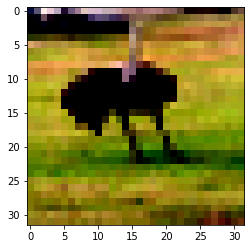

In [ ]:
img_t, _ = transformed_cifar10[42]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## Classifying birds and airplanes

In [ ]:
from torchvision import datasets, transforms
data_path = './data-unversioned'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
# prepare dataset for only birds and airplanes
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val  = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [ ]:
# build a model for classification
# simple model with linear output
import torch.nn as nn

n_out = 2

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out)
)

In [ ]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [ ]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [ ]:
# actually workds with nn.Softmax()
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


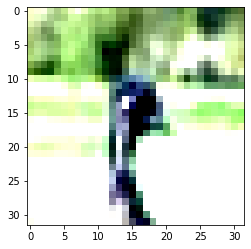

In [ ]:
# sample image
img, _ = cifar2[10]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
img_batch = img.view(-1).unsqueeze(0)

In [ ]:
out = model(img_batch)
out

tensor([[0.4717, 0.5283]], grad_fn=<SoftmaxBackward>)

In [ ]:
_, index = torch.max(out, dim=1)

index

tensor([1])

In [ ]:
# converting target to trainable data
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4, 2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [ ]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [ ]:
# we can also concentrate only on the correct label
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [ ]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [ ]:
# using neg_log_likelihood
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [ ]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong


nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out2, out3]])
nll_comparison

tensor([0.7905, 1.6015, 2.9878])

In [ ]:
# to use NLL, use logsoftmax at the last layer

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()

img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.5395, grad_fn=<NllLossBackward>)

In [ ]:
# train the whole dataset
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imag, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.724644
Epoch: 1, Loss: 0.724644
Epoch: 2, Loss: 0.724644
Epoch: 3, Loss: 0.724644
Epoch: 4, Loss: 0.724644
Epoch: 5, Loss: 0.724644
Epoch: 6, Loss: 0.724644
Epoch: 7, Loss: 0.724644
Epoch: 8, Loss: 0.724644
Epoch: 9, Loss: 0.724644
Epoch: 10, Loss: 0.724644
Epoch: 11, Loss: 0.724644
Epoch: 12, Loss: 0.724644
Epoch: 13, Loss: 0.724644
Epoch: 14, Loss: 0.724644
Epoch: 15, Loss: 0.724644
Epoch: 16, Loss: 0.724644
Epoch: 17, Loss: 0.724644
Epoch: 18, Loss: 0.724644
Epoch: 19, Loss: 0.724644
Epoch: 20, Loss: 0.724644
Epoch: 21, Loss: 0.724644
Epoch: 22, Loss: 0.724644
Epoch: 23, Loss: 0.724644
Epoch: 24, Loss: 0.724644
Epoch: 25, Loss: 0.724644
Epoch: 26, Loss: 0.724644
Epoch: 27, Loss: 0.724644
Epoch: 28, Loss: 0.724644
Epoch: 29, Loss: 0.724644
Epoch: 30, Loss: 0.724644
Epoch: 31, Loss: 0.724644
Epoch: 32, Loss: 0.724644
Epoch: 33, Loss: 0.724644
Epoch: 34, Loss: 0.724644
Epoch: 35, Loss: 0.724644
Epoch: 36, Loss: 0.724644
Epoch: 37, Loss: 0.724644
Epoch: 38, Loss: 0.724

In [ ]:
# more conveniently, use DataLoader
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [ ]:
# get accuracy for train dataset
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

In [ ]:
# for validation dataset
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [ ]:
# we can also use crossentropyloss instead of softmax and NLL
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [ ]:

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

## getting number of parameters

In [ ]:
sum([p.numel() for p in model.parameters()])

In [ ]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

In [ ]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])